Alunos: João Martinho e Gustavo Guerreiro

# TRABALHO PARCIAL 01 [OPERADORES MORFOLÓGICOS]

Escolha e implemente um artigo que utilize as técnicas de Morfologia Matemática.  
Obs.: o artigo precisa ser validado com o professor.

Inicialmente, importa-se as bibliotecas matplotlib, cv2 e numpy para realizar as operações necessárias.

In [ ]:
%pip install matplotlib
%pip install opencv-python
%pip install numpy

In [1]:
from matplotlib import pyplot as plt
import cv2
import numpy as np

## Extração da imagem

Para essa aplicação foi escolhida uma foto semelhante à utilizada no artigo original, na região do município de Santarém no Pará. O artigo faz uso de fotos do sensor TM (Thematic Mapper) obtidas através de satélites, apesar do método utilizado para extração de imagens não ser explícito, considerando as referências utilizadas e a utilização da imagem em três bandas (3, 4 e 5), entendeu-se que o satélite utilizado foi o Landset 5, que separa as imagens em três bandas (faixas de comprimento de onda registradas pelo sensor). Nesse caso as faixas de bandas utilzadas pelos autores foram:

| Banda | Faixa Espectral $\mu\text{m}$ |
|----------|----------|
| 3 (Vermelho) | 0,63 – 0,69 |
| 4 (Infravermelho próximo) | 0,76 – 0,90 |
| 5 (Infravermelho médio) | 1,55 – 1,75 |

As imagens detectadas por esse satélite estão disponíveis no serviço EarthExplorer da USGS (United States Geological Survey), neste serviço foi feita uma busca pelo dataset Landsat 4-5 TM C2 L1, e uma foto da região metropolitana de Santarém com baixa densidade de nuvens (como o artigo sugere) foi escolhida. Para se assemelhar mais ao artigo original, as imagens adquiridas no EarthExplorer foram recortadas para abrangerem apenas a região de Santarém. Observando as imagens do artigo, percebe-se a ausência do rio na banda 3, apesar desta estar presente na original, por isso foi realizado um tratamento inicial usando o Google Earth Engine para usar a banda 5 como base para remover os corpos de água da banda 3 e ficar apenas com a terra, exatamente como no artigo. Segue o script utilizado no Google Earth Engine para fazer a retirada dos corpos de água e exportar as imagens do satélite:

```javascript
// A variável "santarém" foi desenhada como um retângulo
// por meio da interface do Google Earth Explorer

// Adquirindo as fotos do LandSat 5 segundo as informções do EarthExplorer
var collection = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')
  .filterBounds(santarem)
  .filterDate('2010-01-01', '2012-12-31')
  .filter(ee.Filter.lt('CLOUD_COVER', 5));

// Como o filtro foi específico a primeira imagem adquirida já está boa
var image = collection.first();


// Removendo os corpos de água com base nas bandas 2 e 5
var green = image.select('SR_B2');
var swir1 = image.select('SR_B5');
var mndwi = green.subtract(swir1).divide(green.add(swir1));
var waterMask = mndwi.gt(0);
var masked = image.updateMask(waterMask.not());

// Exportando as bandas dejedas (3 sem água, 4, 5 e a composição das três bandas juntas)
Export.image.toDrive({
  image: masked.select(['SR_B3']),
  description: 'Santarem3semagua',
  scale: 30,
  region: santarem,
  fileFormat: 'GeoTIFF'
});

Export.image.toDrive({
  image: image.select(['SR_B4']),
  description: 'Santarem4',
  scale: 30,
  region: santarem,
  fileFormat: 'GeoTIFF'
});

Export.image.toDrive({
  image: image.select(['SR_B5']),
  description: 'Santarem5',
  scale: 30,
  region: santarem,
  fileFormat: 'GeoTIFF'
});

Export.image.toDrive({
  image: image.select(['SR_B3', 'SR_B4', 'SR_B5']),
  description: 'Santarem345',
  scale: 30,
  region: santarem,
  fileFormat: 'GeoTIFF'
});

```

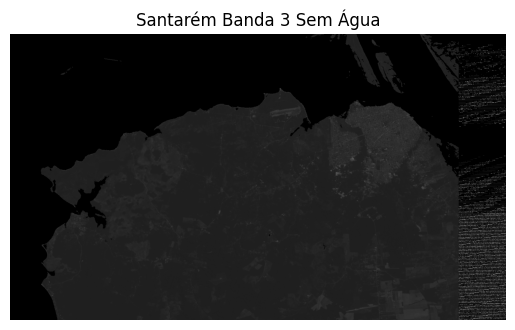

In [24]:
imagem = cv2.imread('Santarem3semagua.tif')
if len(imagem.shape) == 3:
    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

plt.axis('off')
plt.title('Santarém Banda 3 Sem Água')
plt.imshow(imagem, 'gray')
plt.show()

## Tratamento da imagem

Tendo a imagem extraída e com seu brilho aumentado para facilitar a vizualização, aplica-se a binzarização para ficar apenas com os principais elementos da imagem.

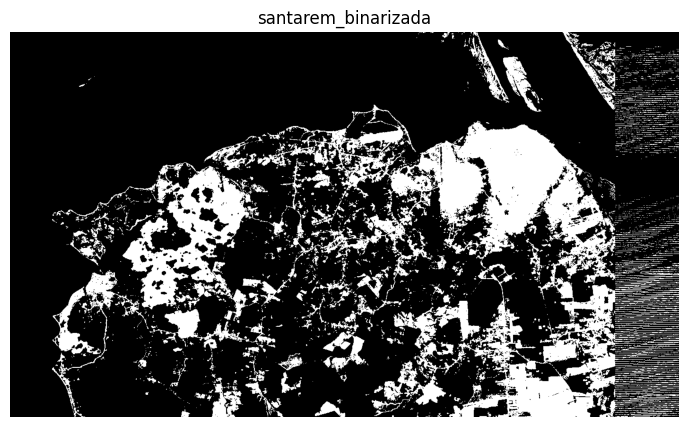

In [46]:
(T, binaria) = cv2.threshold(imagem, 33, 255, cv2.THRESH_BINARY)
plt.figure(figsize=(10, 5))
plt.title('santarem_binarizada')
plt.axis("off")
plt.imshow(binaria, 'gray')

O artigo original usa um elemento estrurante (também chamado de *kernel*) de formato octogonal,  tal formato foi reproduzido em uma matriz 5x5.

In [49]:
kernel = np.array([
    [0, 1, 1, 1, 0],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [0, 1, 1, 1, 0]
], dtype=np.uint8)

Em seguida se aplica o elemento estruturante à imagem binarizada. Deixando explícito as zonas com mais desmatamento, com destaque para a região metropolitana de Santarém, o aeroporto, a região da savana e o munícipio de Alter do Chão com suas praias, extamente como no artigo original.

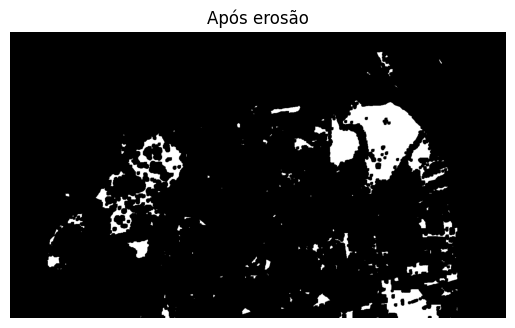

In [50]:
erodida = cv2.erode(binaria, kernel, iterations=2)

plt.axis('off')
plt.title("Após erosão")
plt.imshow(erodida, 'gray')

O artigo segue destacando as bordas obtidas com a erosão em vermelho, para isso foi utilizado a função findContours do OpenCV para encontrar os contornos das formas e então desenhá-los.

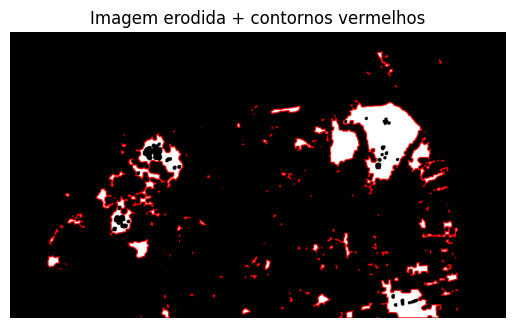

In [54]:
bordas, hierarquia = cv2.findContours(erodida, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

imagem_colorida = cv2.cvtColor(erodida, cv2.COLOR_GRAY2BGR)
cv2.drawContours(imagem_colorida, bordas, -1, (0,0,255), thickness=2)

plt.title("Imagem erodida + contornos vermelhos")
plt.axis("off")
plt.imshow(cv2.cvtColor(imagem_colorida, cv2.COLOR_BGR2RGB))

Referências:

Google. **Google Earth Engine**. Disponível em: https://earthengine.google.com/. Acesso em: 8 set. 2025.

GUERRA, Carlos Eduardo. **Detecção de zonas de baixa cobertura vegetal em imagens de satélites através do uso de operadores da Morfologia Matemática**. SIMPÓSIO BRASILEIRO DE SENSORIAMENTO REMOTO, 13., 2007, Florianópolis.

U.S. GEOLOGICAL SURVEY. **EarthExplorer**. [S. l.]. Disponível em: https://earthexplorer.usgs.gov/. Acesso em: 6 set. 2025.

U.S. GEOLOGICAL SURVEY. **What are the band designations for Landsat satellites?**. [S. l.]. Disponível em: https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites. Acesso em: 6 set. 2025.